In [1]:
import numpy as np
from scipy.io import loadmat

# 1) mat 파일 읽기
data = loadmat('graph_topologies_only.mat')

graph_k4_add = data['graph_k4_add']   # shape: (64, 64, 2, 8, 4)

print(graph_k4_add.shape)  # 확인용 → (64, 64, 2, 8, 4)

# 2) 예시용 인덱스 선택
#   - loop      = 0  (MATLAB loop=1)
#   - del_per   = 50% → del_per_list[2] → index 2
#   - pa        = 2/3 → pa_list[2]      → index 2
loop_idx   = 0
del_idx    = 2
pa_idx     = 2

A = graph_k4_add[:, :, loop_idx, del_idx, pa_idx]   # (64, 64) adjacency
print(A.shape, A.sum())  # adjacency 확인

(64, 64, 2, 8, 4)
(64, 64) 576


In [2]:
import networkx as nx

G = nx.from_numpy_array(A)        # undirected graph
endpoints = list(G.nodes())       # [0, 1, ..., 63]

print("노드 개수:", len(endpoints))
print("평균 degree:", np.mean([d for _, d in G.degree()]))


노드 개수: 64
평균 degree: 9.0


In [3]:
import trafpy.generator as tpg

# 1) 노드 분포: 모든 노드가 src/dst로 균등하게 선택
node_dist = tpg.gen_uniform_node_dist(eps=endpoints)

# 2) 플로우 크기 분포 (예: 10KB, 100KB, 1MB가 각각 0.5, 0.3, 0.2 비율)
flow_size_dist = {
    10_000: 0.5,
    100_000: 0.3,
    1_000_000: 0.2,
}

# 3) inter-arrival time 분포 (예: 1ms 간격 고정)
interarrival_time_dist = {0.001: 1.0}


In [4]:
# 링크 수와 평균 degree를 이용해서 적당한 capacity 잡기
num_edges = G.number_of_edges()
avg_degree = np.mean([d for _, d in G.degree()])

# 한 링크당 capacity를 1.0이라고 두고, 전체 capacity 계산
link_capacity = 1.0
network_rate_capacity = num_edges * link_capacity

# 엔드포인트 링크 capacity는 평균 degree 기준으로 대충 맞춤
ep_link_capacity = avg_degree * link_capacity

network_load_config = {
    'network_rate_capacity': network_rate_capacity,
    'ep_link_capacity': ep_link_capacity,
    'target_load_fraction': 0.1,   # 전체 capacity의 10% 부하를 목표로
}
print(network_load_config)


{'network_rate_capacity': 288.0, 'ep_link_capacity': 9.0, 'target_load_fraction': 0.1}


In [5]:
demand_data = tpg.create_demand_data(
    eps=endpoints,
    node_dist=node_dist,
    flow_size_dist=flow_size_dist,
    interarrival_time_dist=interarrival_time_dist,
    network_load_config=network_load_config,
    jensen_shannon_distance_threshold=0.9,
)

type(demand_data), demand_data.keys()


/home/disclose/miniconda3/envs/traf36/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Packed 6000 flows in 2.261 s | Node distribution Jensen Shannon distance from target achieved: 0.4201005146691214


(dict,
 dict_keys(['flow_id', 'sn', 'dn', 'flow_size', 'event_time', 'establish', 'index']))

In [6]:
# 플로우 정보가 들어있는 DataFrame (이름은 버전에 따라 다를 수 있음)
for k in demand_data.keys():
    print(k, type(demand_data[k]))

# 가장 그럴싸한 테이블 하나 골라서 head 보기
import pandas as pd

# 예: demand_data['demand_df'] 같은 게 있으면
if 'demand_df' in demand_data:
    flows_df = demand_data['demand_df']
    display(flows_df.head())


flow_id <class 'list'>
sn <class 'list'>
dn <class 'list'>
flow_size <class 'list'>
event_time <class 'numpy.ndarray'>
establish <class 'list'>
index <class 'numpy.ndarray'>


In [7]:
import pandas as pd
import numpy as np

flows_df = pd.DataFrame({
    'flow_id':    demand_data['flow_id'],
    'src':        demand_data['sn'],
    'dst':        demand_data['dn'],
    'flow_size':  demand_data['flow_size'],
    'event_time': np.asarray(demand_data['event_time']).reshape(-1),
    'establish':  demand_data['establish'],
    'idx':        np.asarray(demand_data['index']).reshape(-1),
})

print(flows_df.shape)
flows_df.head(10)


(6000, 7)


,flow_id,src,dst,flow_size,event_time,establish,idx
0,flow_5824,10,38,10000,0.000000,1,0
1,flow_5496,27,30,10000,8017.829360,1,1
2,flow_5515,31,15,10000,16035.658721,1,2
3,flow_2028,36,44,100000,24053.488081,1,3
4,flow_5483,60,41,10000,32071.317442,1,4
5,flow_2946,9,41,100000,40089.146802,1,5
6,flow_3541,48,44,10000,48106.976163,1,6
7,flow_4482,10,6,10000,56124.805523,1,7
8,flow_4200,63,0,10000,64142.634884,1,8
9,flow_5454,14,22,10000,72160.464244,1,9


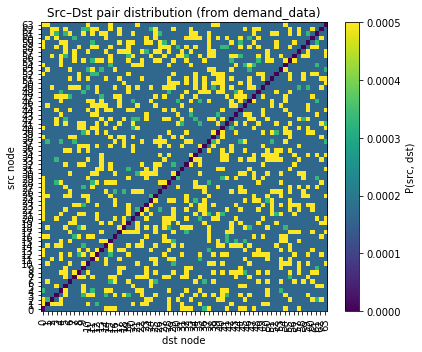

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from trafpy.generator.src.dists import val_dists

# 1) demand_data에서 src/dst 꺼내기
sn = np.array(demand_data['sn'])
dn = np.array(demand_data['dn'])

# eps = 엔드포인트 라벨들 (0~63)
eps = sorted(set(sn.tolist()) | set(dn.tolist()))

# 2) (src, dst) 쌍 리스트 만들기
sampled_pairs_list = list(zip(sn, dn))

# 3) TrafPy의 val_dists로 (src,dst) -> count 딕셔너리 만들기
pair_occ = val_dists.convert_data_to_key_occurrences(sampled_pairs_list)
# pair_occ: { (src, dst): occurrence_count }

# 4) 확률 분포로 정규화
total_count = sum(pair_occ.values())
pair_prob = {pair: cnt / total_count for pair, cnt in pair_occ.items()}

# 5) eps 인덱스 매핑
idx = {ep: i for i, ep in enumerate(eps)}

# 6) src–dst 확률 행렬 만들기
node_dist_matrix = np.zeros((len(eps), len(eps)), dtype=float)

for (s, d), p in pair_prob.items():
    i = idx[s]
    j = idx[d]
    node_dist_matrix[i, j] = p

# 7) 히트맵 시각화
plt.figure(figsize=(6, 5))
im = plt.imshow(node_dist_matrix, origin="lower", aspect="auto")
plt.colorbar(im, label="P(src, dst)")
plt.xticks(range(len(eps)), eps, rotation=90)
plt.yticks(range(len(eps)), eps)
plt.xlabel("dst node")
plt.ylabel("src node")
plt.title("Src–Dst pair distribution (from demand_data)")
plt.tight_layout()
plt.show()


flow_size 값들: [  10000  100000 1000000]
각 값의 개수: [3015 1811 1174]


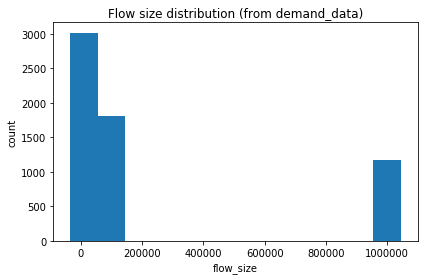

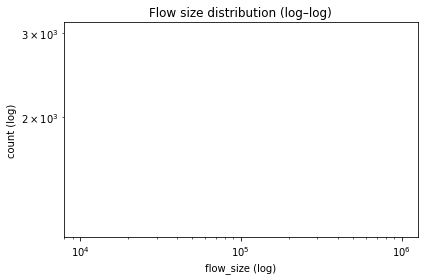

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from trafpy.generator.src.dists import val_dists

# 1) flow_size 배열 꺼내기
flow_size = np.array(demand_data['flow_size'])

# 2) TrafPy 유틸로 값 -> 발생횟수 딕셔너리
flow_size_occ = val_dists.convert_data_to_key_occurreimport numpy as np
import scipy.io as sio
import trafpy.generator as tpg
import pandas as pd

# 1. k4_add 토폴로지에서 노드 개수/ID만 가져오기
mat = sio.loadmat('graph_topologies_only.mat')

# graph_k4_add shape: (64, 64, n_loop=2, per_size=8, n_pa=4)
graph_k4_add = mat['graph_k4_add']

# 예시로: loop=0, del_per 인덱스=2(중간쯤), pa 인덱스=2(중간쯤) 사용
adj = graph_k4_add[:, :, 0, 2, 2]   # 필요하면 인덱스는 마음대로 바꿔도 됨

num_eps = adj.shape[0]              # 64
eps = list(range(num_eps))         # 엔드포인트 ID를 0~63으로 사용

# 2. HPC/DCN_iii 스타일 노드 로드 분포
#    - 20% hot nodes, 이들이 전체 traffic의 55%를 담당
hot_fraction = 0.20
hot_load_fraction = 0.55

num_hot = int(round(hot_fraction * num_eps))
hot_nodes = eps[:num_hot]          # 편하게 앞에서부터 hot으로 지정 (원하면 랜덤으로 바꿔도 됨)
cold_nodes = eps[num_hot:]

p_hot_each = hot_load_fraction / num_hot
p_cold_each = (1.0 - hot_load_fraction) / len(cold_nodes)

node_dist = {}
for u in eps:
    if u in hot_nodes:
        node_dist[u] = p_hot_each
    else:
        node_dist[u] = p_cold_each

# 확률 합 체크 (디버그용)
print('sum(node_dist)=', sum(node_dist.values()))nces(flow_size.tolist())
# flow_size_occ: {size_value: count}

# 3) 플롯용 x, y 만들기
x_vals = np.array(sorted(flow_size_occ.keys()))
y_counts = np.array([flow_size_occ[x] for x in x_vals])

print("flow_size 값들:", x_vals)
print("각 값의 개수:", y_counts)

# 4) 일반 스케일 막대그래프
plt.figure(figsize=(6, 4))
plt.bar(x_vals, y_counts,
        width=(np.diff(x_vals).min() if len(x_vals) > 1 else 1))
plt.xlabel("flow_size")
plt.ylabel("count")
plt.title("Flow size distribution (from demand_data)")
plt.tight_layout()
plt.show()

# 5) heavy-tailed 여부 보기 위한 log–log 스케일
plt.figure(figsize=(6, 4))
plt.bar(x_vals, y_counts)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("flow_size (log)")
plt.ylabel("count (log)")
plt.title("Flow size distribution (log–log)")
plt.tight_layout()
plt.show()

inter-arrival 값들 (일부): [8017.82936045 8017.82936045 8017.82936045 8017.82936045 8017.82936045
 8017.82936045 8017.82936045 8017.82936045]
각 값의 개수 (일부): [4950  263   13    4  244  523    1    1]


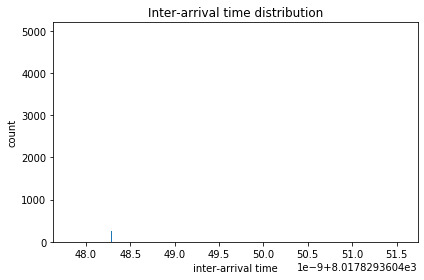

In [10]:
# 1) event_time 꺼내기 (numpy array로 변환)
event_time = np.array(demand_data['event_time']).astype(float).reshape(-1)

# 2) 시간 순서로 정렬 후, 차분 = inter-arrival
sorted_times = np.sort(event_time)
inter_arrivals = np.diff(sorted_times)

# 0 간격(동일 타임스탬프) 제거하고 싶으면:
inter_arrivals = inter_arrivals[inter_arrivals > 0]

# 3) TrafPy 유틸로 값 -> 발생횟수 딕셔너리
ia_occ = val_dists.convert_data_to_key_occurrences(inter_arrivals.tolist())
# ia_occ: {delta_t: count}

x_ia = np.array(sorted(ia_occ.keys()))
y_ia = np.array([ia_occ[x] for x in x_ia])

print("inter-arrival 값들 (일부):", x_ia[:10])
print("각 값의 개수 (일부):", y_ia[:10])

# 4) 막대그래프
plt.figure(figsize=(6, 4))
plt.bar(x_ia, y_ia,
        width=(np.diff(x_ia).min() if len(x_ia) > 1 else 1))
plt.xlabel("inter-arrival time")
plt.ylabel("count")
plt.title("Inter-arrival time distribution")
plt.tight_layout()
plt.show()
